# **Projekt: Fehlererkennung in Getrieben**
## Netztyp 2: FFT-Net

#### **Vorbereitung**

In [98]:
# import libraries
import numpy as np
import os
from pandas import DataFrame, concat
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)

import src.data_loader as dl
import src.visualization as vis
import src.model_constructor as mc

In [99]:
# set the source directory for the preprocessed data to use
SOURCE: str = "ef15f799-1a24-4d25-8a7f-1be8024534a3"

# setup a single index for control purposes
CONTROL_INDEX: int = 1

In [100]:
# setup system and check the number of cpu cores and gpus available
mc.system_setup()

Number of CPU cores:		12
Number of GPUs available:	0


#### **Laden der Datensätze**

In [101]:
# load data from folder and split in training and evaluation data
data_path = Path().cwd() / "data" / "processed" / SOURCE
development_data, evaluation_data = dl.load_all_datasets(data_path)

READING DEVELOPMENT DATA
0D_0_fft.csv successfully loaded.
0D_1_fft.csv successfully loaded.
1D_0_fft.csv successfully loaded.
1D_1_fft.csv successfully loaded.
2D_0_fft.csv successfully loaded.
2D_1_fft.csv successfully loaded.
3D_0_fft.csv successfully loaded.
3D_1_fft.csv successfully loaded.
4D_0_fft.csv successfully loaded.
4D_1_fft.csv successfully loaded.
READING EVALUATION DATA
0E_0_fft.csv successfully loaded.
0E_1_fft.csv successfully loaded.
1E_0_fft.csv successfully loaded.
1E_1_fft.csv successfully loaded.
2E_0_fft.csv successfully loaded.
2E_1_fft.csv successfully loaded.
3E_0_fft.csv successfully loaded.
3E_1_fft.csv successfully loaded.
4E_0_fft.csv successfully loaded.
4E_1_fft.csv successfully loaded.
READING COMPLETED


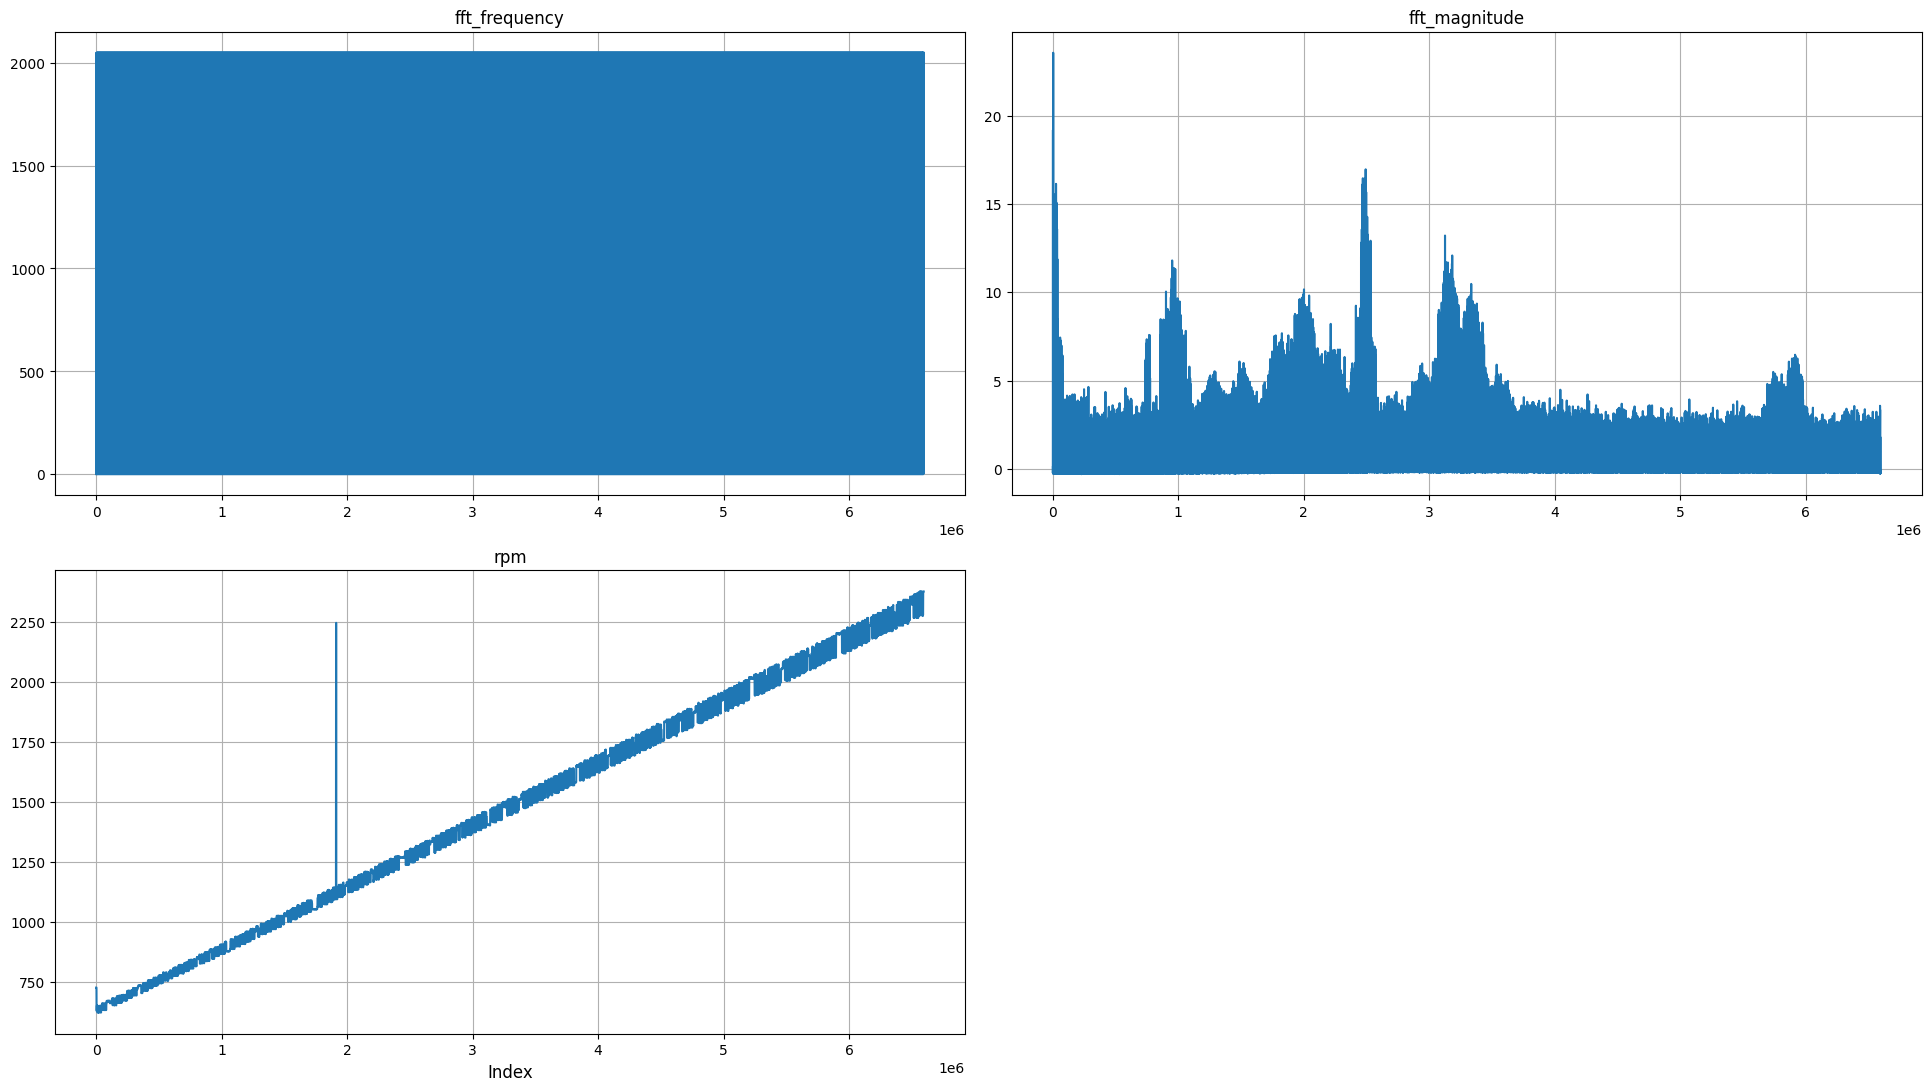

In [102]:
# visualize one random dataset for data validation
vis.plot_columns_as_subplots(development_data[CONTROL_INDEX],
                             development_data[CONTROL_INDEX].columns)

#### **Das Neuronale Netz**



In [103]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from pandas import concat

def shuffle_data_and_labels(data, labels):
    # Überprüfen, ob die Anzahl der Datenpunkte und Labels gleich ist
    assert data.shape[0] == labels.shape[0], "Anzahl der Datenpunkte muss der Anzahl der Labels entsprechen."
    
    # Erzeuge einen zufälligen Index
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    
    # Wende den zufälligen Index auf beide Arrays an
    shuffled_data = data[indices]
    shuffled_labels = labels[indices]
    
    return shuffled_data, shuffled_labels


index = 1
def prepare_data_for_input(datasets: list[DataFrame]):
    keys = []
    for index, dataset in enumerate(datasets):
        keys.append(dataset.attrs["path"].stem)

        # if dataset.attrs["unbalance"] == "none":
        #     dataset["label"] = "none"
        # else:
        #     dataset["label"] = "some"

        dataset["label"] = dataset.attrs["unbalance"]
        datasets[index] = dataset

    return concat(datasets, keys=keys)


ds = prepare_data_for_input(development_data)

display(ds)

training_samples = ds["fft_magnitude"].to_numpy()
training_labels = ds["label"].to_numpy()



training_samples = np.reshape(training_samples, (-1, 2048))
training_labels = np.reshape(training_labels, (-1, 2048))
training_labels = training_labels[:,0]

# encode labels

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(training_labels)
y_one_hot = to_categorical(y_encoded, num_classes=5)


training_samples, y_one_hot = shuffle_data_and_labels(training_samples, y_one_hot)

print(training_samples.shape)
print(y_one_hot.shape)

fft_frequency  fft_magnitude          rpm   label
0D_0_fft 0                  1.0      66.468332   640.782603    none
         1                  2.0      32.948368   640.782603    none
         2                  3.0      21.774169   640.782603    none
         3                  4.0      16.236190   640.782603    none
         4                  5.0      13.088005   640.782603    none
...                         ...            ...          ...     ...
4D_1_fft 6592507         2044.0      -0.040120  2371.839888  strong
         6592508         2045.0      -0.061268  2371.839888  strong
         6592509         2046.0      -0.081246  2371.839888  strong
         6592510         2047.0       0.007892  2371.839888  strong
         6592511         2048.0      -0.133122  2371.839888  strong

[65839104 rows x 4 columns]

(32148, 2048)
(32148, 5)


In [104]:
# Klassen
# Extrahieren der eindeutigen Klassenbezeichnungen
unique_classes = np.unique(training_labels)  # Eindeutige Klassen im Datensatz
class_names = [str(cls) for cls in unique_classes]  # In Strings konvertieren (optional)

print("Eindeutige Klassen im Datensatz:", class_names)

# Klassenverteilung anzeigen
class_counts = np.sum(y_one_hot, axis=0)  # Summiere jede Spalte im One-Hot-Encoding
print("Klassenverteilung:", class_counts)

Eindeutige Klassen im Datensatz: ['moderat', 'none', 'significant', 'slight', 'strong']
Klassenverteilung: [6430. 6430. 6429. 6430. 6429.]


In [105]:
LEARNING_RATE: float = 0.0001
MOMENTUM: float = 0.8 #0.9
BATCH_SIZE: int = 32 #64
EPOCHS: int = 50
THRESHOLD = 0.5 #0.95
NUMBER_OF_HIDDEN_LAYERS: int = 2

In [106]:
import keras
from keras import layers, regularizers
input_shape = training_samples.shape
output_shape = y_one_hot.shape
print(output_shape)


model = keras.Sequential()
model.add(layers.Dense(2048, input_shape=(input_shape[1],)))

# add the number of hidden layers
for _ in range(NUMBER_OF_HIDDEN_LAYERS):
    model.add(layers.Dense(units = 1024,
                           kernel_regularizer=regularizers.L2(0.001)))
    model.add(layers.LeakyReLU(negative_slope=0.3))
    model.add(layers.Dropout(0.2))
    

model.add(layers.Dense(output_shape[1], activation="sigmoid"))

model.summary()

(32148, 5)


c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,349,253 (28.04 MB)

 Trainable params: 7,349,253 (28.04 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
# Early Stopping when loss does not change after some epochs
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Überwachung der Validierungsverlustes
    patience=10,         # Training stoppt, wenn sich die val_loss nach 10 Epochen nicht verbessert
    restore_best_weights=True
)


In [108]:
# set Class Weights
class_weights_dict = {
    0: 0.7,  # none (Klasse 0) wird weniger stark gewichtet
    1: 1.5,  # slight (Klasse 1) wird stärker gewichtet
    2: 1.0,  # moderate (Klasse 2) wird leicht erhöht
    3: 1.2,  # significant (Klasse 3) bleibt gleich
    4: 0.7   # strong (Klasse 4) wird weniger stark gewichtet
}


In [109]:

'''
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],
)

model.fit(x=training_samples,y=y_one_hot, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

'''


model.compile(
    # optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, name="adam"),
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss = keras.losses.CategoricalCrossentropy(), # für Multiklassen
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(name="precision", thresholds=THRESHOLD),
        keras.metrics.Recall(name="recall", thresholds=THRESHOLD),
    ],
)

history = model.fit(
    x=training_samples,
    y=y_one_hot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    shuffle=True,
    # callbacks=[early_stopping],
    class_weight=class_weights_dict
)


Epoch 1/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - accuracy: 0.3568 - loss: 3.8183 - precision: 0.2558 - recall: 0.7878 - val_accuracy: 0.7263 - val_loss: 3.3430 - val_precision: 0.3370 - val_recall: 0.9689
Epoch 2/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.7123 - loss: 3.2405 - precision: 0.3399 - recall: 0.9679 - val_accuracy: 0.8488 - val_loss: 2.9883 - val_precision: 0.3564 - val_recall: 0.9869
Epoch 3/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.8360 - loss: 2.9388 - precision: 0.3593 - recall: 0.9872 - val_accuracy: 0.9160 - val_loss: 2.7838 - val_precision: 0.3698 - val_recall: 0.9932
Epoch 4/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.8918 - loss: 2.7767 - precision: 0.3685 - recall: 0.9918 - val_accuracy: 0.9474 - val_loss: 2.6679 - val_precision: 0.3792 - val_recall: 0.9944
Epoch 5/50
905/905 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.9250 - loss: 2.6765 - precision: 0.3773 - recall: 0.9939 - val_accuracy: 0.9630 - va

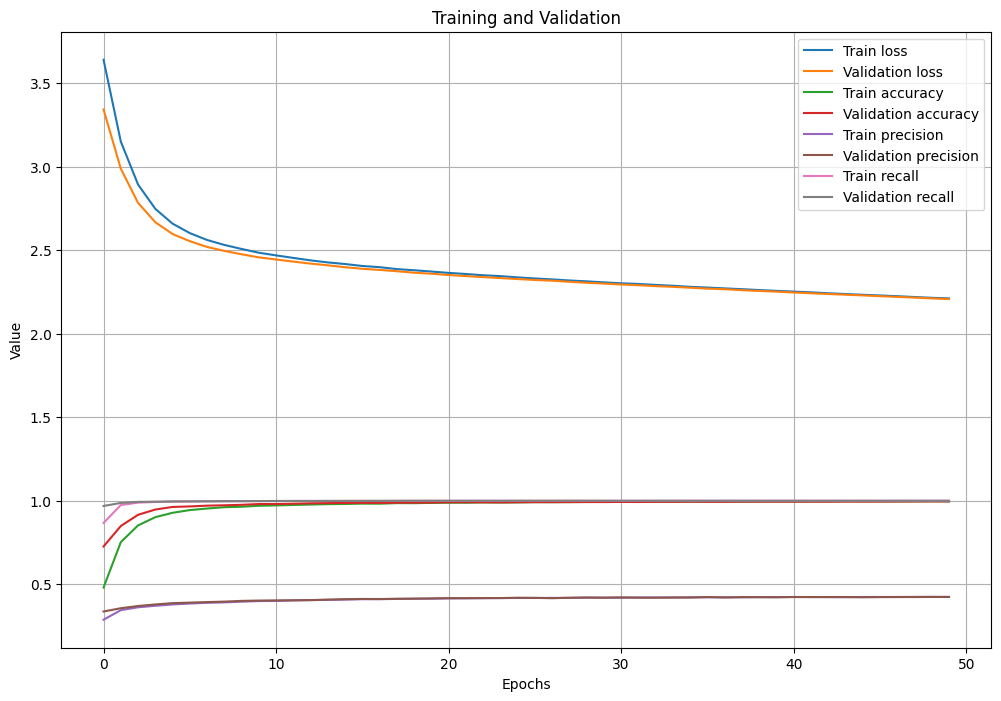

In [110]:
# visualize training metrics
vis.plot_training_history(history, metrics=["loss", "accuracy", "precision", "recall"])

In [111]:
test_dataset = prepare_data_for_input(evaluation_data)

test_samples = test_dataset["fft_magnitude"].to_numpy()
test_labels = test_dataset["label"].to_numpy()

test_samples = np.reshape(test_samples, (-1, 2048))
test_labels = np.reshape(test_labels, (-1, 2048))
test_labels = test_labels[:,0]

# encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(test_labels)
y_one_hot = to_categorical(y_encoded, num_classes=5)


test_samples, test_labels = shuffle_data_and_labels(test_samples, y_one_hot)

print(test_samples.shape)
print(test_labels.shape)

(8347, 2048)
(8347, 5)


In [112]:
print(test_labels)

# Klassenverteilung in den Testdaten
test_class_counts = np.sum(test_labels, axis=0)
print("Klassenverteilung in den Testdaten:", test_class_counts)

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]
Klassenverteilung in den Testdaten: [1668. 1669. 1670. 1670. 1670.]


In [113]:
evaluation = model.evaluate(test_samples, test_labels, verbose=1, return_dict=True)

display(evaluation)

predictions = model.predict(test_samples)

display(predictions)

261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5238 - loss: 4.6351 - precision: 0.2846 - recall: 0.7815


{'accuracy': 0.5282137393951416,
 'loss': 4.601464748382568,
 'precision': 0.28590139746665955,
 'recall': 0.7844734787940979}

261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([[4.15473740e-04, 1.96190905e-02, 9.86501694e-01, 4.78116602e-01,
        9.99868214e-01],
       [9.28505540e-01, 9.95259166e-01, 9.86295640e-01, 8.81444942e-03,
        1.76593121e-02],
       [9.40372765e-01, 9.92047966e-01, 9.84039068e-01, 3.08628585e-02,
        4.71454579e-03],
       ...,
       [9.80613351e-01, 9.99991298e-01, 9.25717175e-01, 4.27107187e-03,
        1.34915681e-04],
       [2.69876653e-03, 1.35609675e-02, 9.82055724e-01, 3.06892812e-01,
        9.99843180e-01],
       [5.86123228e-01, 9.99999762e-01, 9.74375010e-01, 3.14225326e-03,
        2.01060509e-04]], dtype=float32)

In [114]:

#predictions = model.predict(test_samples) # training_samples
predicted_classes = np.argmax(predictions, axis=1)
predicted_label = encoder.inverse_transform(predicted_classes)
print(predicted_label)

['strong' 'none' 'none' ... 'none' 'strong' 'none']


In [115]:
# Verifizieren, dass die Testdaten und Labels übereinstimmen
assert test_samples.shape[0] == predictions.shape[0], "Die Anzahl der Testdaten und Vorhersagen stimmen nicht überein."
assert test_samples.shape[0] == test_labels.shape[0], "Testdaten und Labels haben unterschiedliche Längen."

print("Erste Labels:", test_labels[:5])
print("Erste Vorhersagen:", predictions[:5])

Erste Labels: [[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]
Erste Vorhersagen: [[4.1547374e-04 1.9619090e-02 9.8650169e-01 4.7811660e-01 9.9986821e-01]
 [9.2850554e-01 9.9525917e-01 9.8629564e-01 8.8144494e-03 1.7659312e-02]
 [9.4037277e-01 9.9204797e-01 9.8403907e-01 3.0862859e-02 4.7145458e-03]
 [7.5093523e-02 9.7901738e-01 5.8510560e-01 9.2092198e-01 2.9813254e-01]
 [8.3310056e-01 9.9998486e-01 6.7080045e-01 1.7886217e-01 1.3642992e-04]]


In [116]:
#Überprüfen 
print("Shape von test_samples:", test_samples.shape)
print("Shape von test_labels:", test_labels.shape)
print("Shape von predictions:", predictions.shape)

Shape von test_samples: (8347, 2048)
Shape von test_labels: (8347, 5)
Shape von predictions: (8347, 5)


#### Confusion Matrix
Die Confusion Matrix zeigt, wie gut dein Modell zwischen den verschiedenen Klassen unterscheidet. Jede Zelle stellt die Anzahl der Samples dar, die einer bestimmten Klasse zugeordnet wurden (wahre Labels) und wie das Modell diese Klasse vorhergesagt hat (vorhergesagte Labels).



<Figure size 800x800 with 0 Axes>

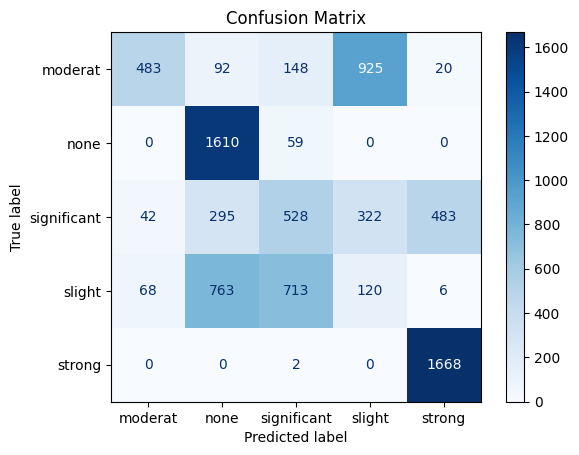

In [117]:
# Confusion Matrix:
true_labels = test_labels.argmax(axis=1)  # One-Hot-Encoding auf numerische Labels zurückführen
predicted_labels = predictions.argmax(axis=1)  # Die wahrscheinlichste Klasse auswählen

# Confusion Matrix plotten
vis.plot_confusion_matrix(true_labels, predicted_labels, class_names)